In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

First, we import the CSV file

In [2]:
csv_path = "orders.csv"
df = pd.read_csv(csv_path)
df.head()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14364873,30000009,2.478101,-72.719360,4200,2017-09-07T20:02:17Z,0
1,14370123,30000058,0.451711,37.754761,4200,2017-09-07T20:13:16Z,0
2,14368534,900003684,2.026072,207.191162,4000,2017-09-07T20:07:23Z,0
3,14370258,900014452,2.671432,1.722656,4400,2017-09-07T20:15:19Z,1
4,14369923,900014085,0.965496,117.429199,3450,2017-09-07T20:12:14Z,1


Next, we count how many orders were taken and not taken:

In [3]:
df['taken'].value_counts()

1    135407
0     11580
Name: taken, dtype: int64

In total, 11580 orders were not taken, and 135407 were taken.
<br>
Next, we describe the dataframe, to get statistical information. Not really necessary for this case, but interesting. nonetheless

In [4]:
df.describe(include="all")

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
count,1.469870e+05,1.469870e+05,146987.000000,146987.000000,146987.000000,146987,146987.000000
unique,NaN,NaN,NaN,NaN,NaN,26914,NaN
top,NaN,NaN,NaN,NaN,NaN,2017-09-23T19:06:05Z,NaN
freq,NaN,NaN,NaN,NaN,NaN,59,NaN
mean,1.507718e+07,7.580708e+08,1.501015,26.899130,5358.641594,NaN,0.921218
std,4.750119e+05,3.214280e+08,0.845776,84.907724,1779.800955,NaN,0.269400
min,1.421073e+07,3.000000e+07,0.000000,-598.296875,0.000000,NaN,0.000000
25%,1.466969e+07,9.000045e+08,0.836511,-18.348755,4200.000000,NaN,1.000000
50%,1.509241e+07,9.000077e+08,1.390230,11.145264,5200.000000,NaN,1.000000
75%,1.547355e+07,9.000127e+08,2.029955,61.024353,6300.000000,NaN,1.000000


In [5]:
df.shape

(146987, 7)

Now we are going to plot the data, to see if we can find any correlation to "taken". We will take total_earning, to_user_distance and to_user_elevation as they are the most likely variables to have any effect on "taken".

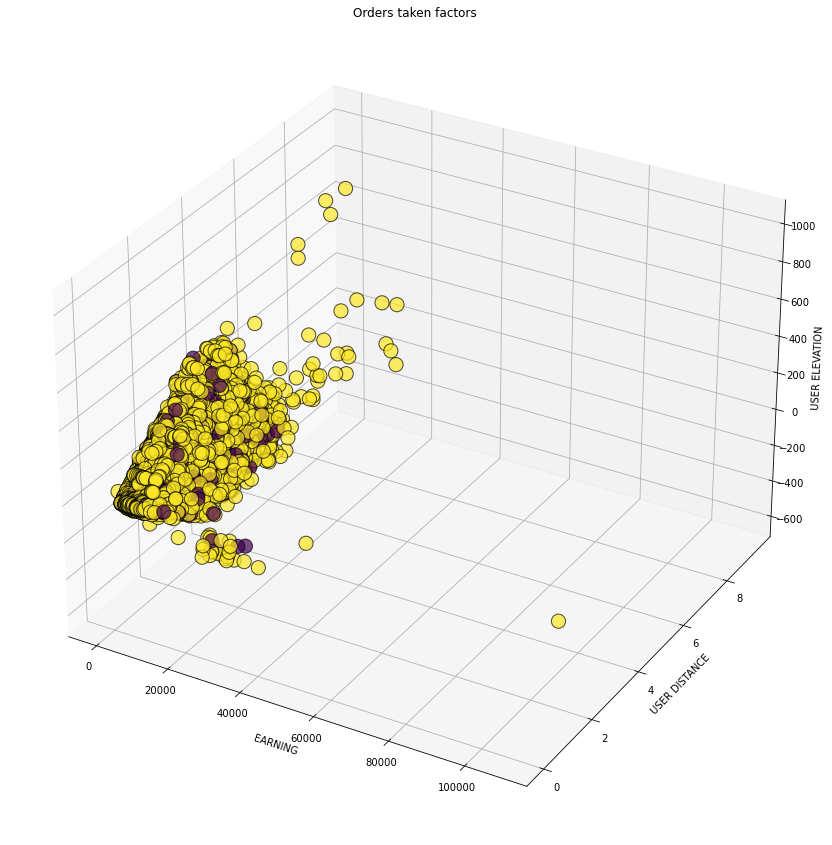

In [41]:
from mpl_toolkits.mplot3d import Axes3D

x = df["total_earning"]
y = df["to_user_distance"]
z = df["to_user_elevation"]
c = df["taken"]
color = ['taken:0', 'taken:1']

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=c)
plt.title("Orders taken factors")
ax.set_xlabel('EARNING')
ax.set_ylabel('USER DISTANCE')
ax.set_zlabel('USER ELEVATION')

plt.show()

From this plot, we can appreciate that among those 3 variables, earning seems to be the most important one when trying to predict if an order is going to be taken or not. 
<br>
We will now apply the k-nearest neighbor algorithm to build our model. We chose this algorith as it seems well suited for predicting the dependent variable Y "taken" from the dependent variables X . For this we will build a classifier.
<br>
First we create a numpy array, each for X and Y:

In [63]:
X = df[['to_user_distance', 'to_user_elevation', 'total_earning', 'taken']].values  

In [64]:
y = df['taken'].values

Since KNN is based on the distance to points, it's a good idea to standarize our data:

In [65]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 1.15525699, -1.17325993, -0.65099725, -3.4195289 ],
       [-1.24064589,  0.12785253, -0.65099725, -3.4195289 ],
       [ 0.6208006 ,  2.12339511, -0.76336975, -3.4195289 ],
       [ 1.383842  , -0.29651672, -0.53862476,  0.29243794],
       [-0.63317153,  1.06622075, -1.07239412,  0.29243794]])

Now we will make a Test/Train split of our dataset.

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Training set:', X_train.shape,  y_train.shape)
print ('Testing set:', X_test.shape,  y_test.shape)

Training set: (117589, 4) (117589,)
Testing set: (29398, 4) (29398,)


Now we will train our model with the the training data set. We start using a number of neighbors, K, of 1:

In [67]:
from sklearn.neighbors import KNeighborsClassifier

In [68]:
k = 1
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

And now we will use our testing set on the model, and check the results of "taken" for the first ten registries:

In [69]:
yhat = neigh.predict(X_test)
yhat[0:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [70]:
unique, counts = np.unique(yhat, return_counts=True)
dict(zip(unique, counts))

{0: 2297, 1: 27101}

Now we will validate the accuracy of our model, with the training and testing sets:

In [71]:
from sklearn import metrics
print("Training set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Testing set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Training set Accuracy:  1.0
Testing set Accuracy:  1.0


From this, we can see that we have an extremely high accuracy in both our sets using this algorithm with K=1.
<br>
Just in case, let's validate our accuracy with other K values, going from 1 to 10:

In [72]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)  
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([1.        , 1.        , 0.99996598, 0.99996598, 0.99996598,
       1.        , 0.99996598, 0.99996598, 0.99993197])

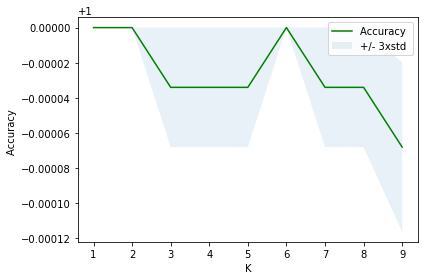

In [73]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('K')
plt.tight_layout()
plt.show()

In [53]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 1.0 with k= 1


As we can see, with either K=1 or K=2, the accuracy is very good, no need to to use more neighbors.

<h2>Conclusions</h2>

At first, I thought and tried using LogisticRegression, due to the nature of Y being a binary value, however, after several tries, I was not able to get valid predictive values. 
<br>
Even though the corrrelation factor of "taken" with "total_earning", "to_user_distance" and "to_user_elevation" was very low in that algorithm, using a k-nearest algorith presented a clearer relationship between X and Y variables. Especially with "total_earning".
<br>
